# Functions for Collecting Data and Modeling

The purpose of this workbook is to consolidate and generalize the code from API_setup.ipynb and PTON_Modeling.ipynb. Once all of code is consolidated then I will be able to quickly collect and model data for any ticker. 

Once I have modeled for a few tickers I'll be able to interperet the results of all the selected tickers as a group.

In [156]:
#Imports
from alpha_vantage.timeseries import TimeSeries
import requests
import pandas as pd
import pandas as pd                        
from pytrends.request import TrendReq
from IPython.display import Image
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller

import warnings

warnings.filterwarnings('ignore')

import datetime as dt

from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [157]:
#see API_setup.ipynb for how I created these functions
def spdr_adj_close():
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=spy&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    return df['5. adjusted close']

def create_ticker_df (ticker):
    '''Returns a DataFrame of stock and Google Trends data for the given ticker. The output will be daily data 1/2/18-6/1/21'''
    #collect stock data using Alpha Vantage API
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey=49KFJCFS3P6CEU4F&outputsize=full'
    r = requests.get(url)
    data = r.json()
    df = pd.DataFrame(data['Time Series (Daily)']).T
    
    #filter to include 2018.01.02 - 2021.06.01
    df['date'] = df.index
    df.index = pd.to_datetime(df['date'])
    df = df[df['date'] > '2018-01-01']
    df = df[df['date'] < '2021-06-02']
    df.drop(columns = 'date', inplace = True)
    df.sort_index(inplace=True)
    
    #add lag columns
    days_to_lag = [1,2,3,7,30,90,365]
    for day in days_to_lag:
        df[f'lag_{day}'] = df['5. adjusted close'].shift(day)
    
    #fix dtypes and column names
    df['spdr_adj_close'] = spdr_adj_close()
   
    
    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    df['daily_returns'] = df['5. adjusted close'] - df['lag_1']
    df['daily_pct_return'] = df['daily_returns']/df['5. adjusted close'].shift(1)
    df['rolling_3d_adj_close'] = df['5. adjusted close'].rolling(3).mean()
    df.rename(columns = {'1. open': 'open',
                        '2. high': 'high',
                        '3. low': 'low',
                        '4. close': 'close',
                        '5. adjusted close': 'adjusted_close',
                        '6. volume': 'volume',
                        '7. dividend amount': 'dividend amount',
                        '8. split coefficient': 'splitcoef',
                        'daily_returns' : 'daily_returns'}, inplace = True)
        
    #Collect Google Trends data using pytrends api
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[ticker])
    google = pytrend.interest_over_time()
    trends = google[ticker].resample('D', convention = 'start').pad()
    trends = pd.DataFrame(trends)
    trends.rename(columns = {ticker:'trend_score'}, inplace = True)
    
    #merge stock data with trends data
    df = df.merge(trends, how = 'left', left_index = True, right_index = True)
    
    return df

In [158]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [159]:
def make_predicted_adj_close_df(start_adj_close, preds):
    mylist = []
    #mylist = [start_adj_close]
    for day in preds:
        try:
            mylist.append(mylist[-1]*(1+day))
        except:
            mylist.append(start_adj_close)
    return mylist

In [160]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [161]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [162]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

---

In [198]:
myticker = 'AMD'
df = create_ticker_df(myticker)

In [199]:
def train_test_split_arima(df):
    y_train = df[df.index < datetime(year = 2021, month = 3, day = 1)]
    y_test = df[df.index > datetime(year = 2021, month = 3, day = 1)]
    y_train = y_train['daily_pct_return']
    y_test = y_test['daily_pct_return'] 
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    y_train.dropna(inplace = True)
    y_test.dropna(inplace = True)
    return y_train, y_test

In [200]:
y_train, y_test = train_test_split_arima(df)

In [201]:
interpret_dftest(adfuller(y_train))

Test Statistic   -1.723634e+01
p-value           6.146990e-30
dtype: float64

In [202]:
def find_best_aic(y_train):
    # Starting AIC, p, and q.
    best_aic = 99 * (10 ** 16)
    best_p = 0
    best_q = 0

    # Use nested for loop to iterate over values of p and q.
    for p in range(5):
        for q in range(5):
        
        # Insert try and except statements.
            try:
            
                # Fitting an ARIMA(p, 1, q) model.
                #print(f'Attempting to fit ARIMA({p},1,{q})')

                # Instantiate ARIMA model.
                arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                              order = (p,1,q)) # values of p, d, q

                # Fit ARIMA model.
                model = arima.fit()

                # Print out AIC for ARIMA(p, 1, q) model.
                #print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q

            except:
                pass
    #print()
    #print()
    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
    print(f'This model has an AIC of {best_aic}.')
    return (best_p,1,best_q)

In [203]:
best_arima_order = find_best_aic(y_train)

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,3).
This model has an AIC of -2978.003825543171.


In [204]:
best_arima_order

(2, 1, 3)

In [205]:
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = best_arima_order)

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params)
preds_cuttoff = preds.shape[0]-64
preds= preds[preds_cuttoff:]

In [206]:
y_train.shape

(793, 1)

In [207]:
preds.shape

(64,)

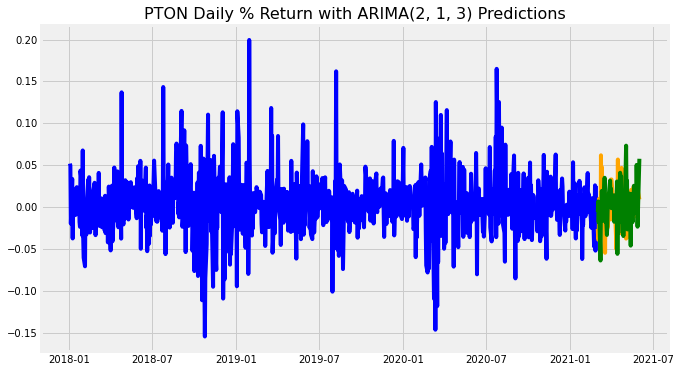

In [208]:
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'PTON Daily % Return with ARIMA(2, 1, 3) Predictions', fontsize=16)
plt.show();

In [209]:
start =df.iloc[-65]['adjusted_close']

In [210]:
predicted_adj_close = make_predicted_adj_close_df(start, preds)

In [211]:
close_train = df[df.index < datetime(year = 2021, month = 3, day = 1)]
close_test = df[df.index > datetime(year = 2021, month = 3, day = 1)]
close_train = close_train['adjusted_close']
close_test = close_test['adjusted_close'] 
close_train = pd.DataFrame(close_train)
close_test = pd.DataFrame(close_test)

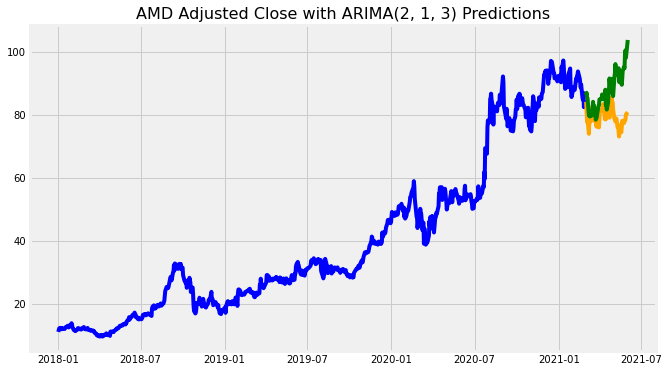

In [212]:
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(close_train.index, pd.DataFrame(close_train), color = 'blue')

# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test), color = 'orange')

# Plot predicted test values.
plt.plot(close_test.index, predicted_adj_close, color = 'green')

plt.title(label = f'{myticker} Adjusted Close with ARIMA{best_arima_order} Predictions', fontsize=16)
plt.show();

# ARIMA Model with Exogeneous Predictors

In [213]:
gt_train = df[df.index < datetime(year = 2021, month = 3, day = 1)]
gt_train['diff_trend_score']= gt_train['trend_score'].diff(1)

gt_train = gt_train['diff_trend_score']

endog = y_train.astype(float).dropna()
exog = sm.add_constant(gt_train.astype(float).dropna())

In [214]:
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=best_arima_order, trend = 't')
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:       daily_pct_return   No. Observations:                  793
Model:               SARIMAX(2, 1, 3)   Log Likelihood                1476.516
Date:                Wed, 14 Jul 2021   AIC                          -2935.032
Time:                        18:15:40   BIC                          -2892.961
Sample:                             0   HQIC                         -2918.863
                                - 793                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
drift             -3.46e-07   9.88e-07     -0.350      0.726   -2.28e-06    1.59e-06
const                     0   6.32e-10          0      1.000   -1.24e-09    1.24e-09
diff_trend_score     0.0011 

In [215]:
preds_with_gt = res.predict()
preds_with_gt = preds_with_gt[preds_cuttoff:]

In [216]:
predicted_adj_close = make_predicted_adj_close_df(start, preds_with_gt)
predicted_adj_close = predicted_adj_close[1:]

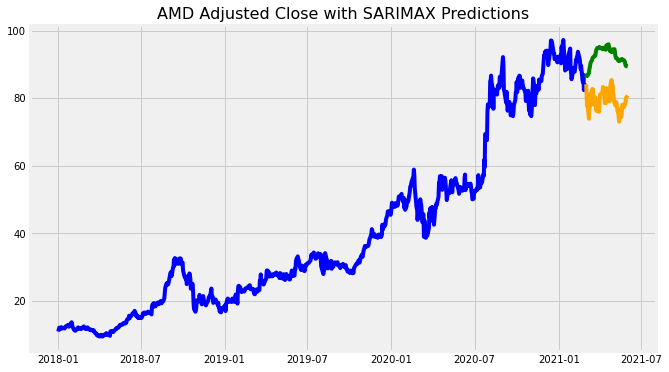

In [217]:
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(close_train.index, pd.DataFrame(close_train), color = 'blue')

# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test), color = 'orange')

# Plot predicted test values.
plt.plot(close_test.index, predicted_adj_close, color = 'green')

plt.title(label = f'{myticker} Adjusted Close with SARIMAX Predictions', fontsize=16)
plt.show();

# Vector Autoregression (VAR) Modeling

In [218]:
maxlag=12
test = 'ssr_chi2test'

grangers_causation_matrix(df, variables = ['adjusted_close', 'trend_score'])

,adjusted_close_x,trend_score_x
adjusted_close_y,1.0,0.0161
trend_score_y,0.0,1.0000


In [219]:
df['trend_score_diff'] = df['trend_score'].diff(1)

In [220]:
df = df[['adjusted_close', 'trend_score']]

In [221]:
#train_test_split
nobs = 30
df_train, df_test = df[0:-nobs], df[-nobs:]

In [222]:
df_differenced = df_train.diff().dropna()

In [223]:
model = VAR(df_differenced)

In [224]:
lowest = 100_000
for i in [1,2,3,4,5,6,7,8,9]:
    print(i)
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    if result.aic < lowest:
        lowest = result.aic
        best_lag = i
    #print('BIC : ', result.bic)
    #print('FPE : ', result.fpe)
    #print('HQIC: ', result.hqic, '\n')

print('\n')
print(f'best lag: {best_lag}')

1
Lag Order = 1
AIC :  2.6052270641594677
2
Lag Order = 2
AIC :  2.608688386122534
3
Lag Order = 3
AIC :  2.6156857904786897
4
Lag Order = 4
AIC :  2.6153098688838634
5
Lag Order = 5
AIC :  2.5476531561687685
6
Lag Order = 6
AIC :  2.5494535532895712
7
Lag Order = 7
AIC :  2.554941267533502
8
Lag Order = 8
AIC :  2.5510712258538755
9
Lag Order = 9
AIC :  2.5367280939064396


best lag: 9


In [225]:
var = model.fit(best_lag)

In [226]:
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jul, 2021
Time:                     18:15:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.75517
Nobs:                     819.000    HQIC:                   2.62055
Log likelihood:          -3325.01    FPE:                    12.6385
AIC:                      2.53673    Det(Omega_mle):         12.0719
--------------------------------------------------------------------
Results for equation adjusted_close
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.097934         0.056064            1.747           0.081
L1.adjusted_close        -0.111270         0.035477           -3.136           0.002
L1.trend_score           -0.013821 

In [227]:
forecast_input = df_differenced.values[-best_lag:]

In [228]:
fc = var.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index[-nobs:], columns=df_train.columns + '_2d')
df_forecast

,adjusted_close_2d,trend_score_2d
date,,
2021-04-20,0.289586,-0.741129
2021-04-21,0.146443,0.692603
2021-04-22,0.745839,0.087031
2021-04-23,-0.430619,0.097529
2021-04-26,0.493929,1.185840
2021-04-27,-0.616158,-0.509897
2021-04-28,0.216677,-0.036018
2021-04-29,0.024301,-0.030205
2021-04-30,0.002747,0.110394


In [229]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results

,adjusted_close_2d,trend_score_2d,adjusted_close_1d,adjusted_close_forecast,trend_score_1d,trend_score_forecast
date,,,,,,
2021-04-20,0.289586,-0.741129,-0.750414,80.359586,-3.741129,58.258871
2021-04-21,0.146443,0.692603,-0.603971,79.755614,-3.048525,55.210346
2021-04-22,0.745839,0.087031,0.141868,79.897482,-2.961494,52.248852
2021-04-23,-0.430619,0.097529,-0.288751,79.608731,-2.863965,49.384887
2021-04-26,0.493929,1.185840,0.205178,79.813909,-1.678125,47.706763
2021-04-27,-0.616158,-0.509897,-0.410980,79.402929,-2.188022,45.518741
2021-04-28,0.216677,-0.036018,-0.194303,79.208626,-2.224040,43.294701
2021-04-29,0.024301,-0.030205,-0.170002,79.038624,-2.254245,41.040455
2021-04-30,0.002747,0.110394,-0.167255,78.871369,-2.143851,38.896604


In [230]:
predicted_adj_close = df_results[['adjusted_close_forecast', 'trend_score_forecast']]

In [231]:
close_test = df_test[df_test.index > datetime(year = 2021, month = 3, day = 1)]

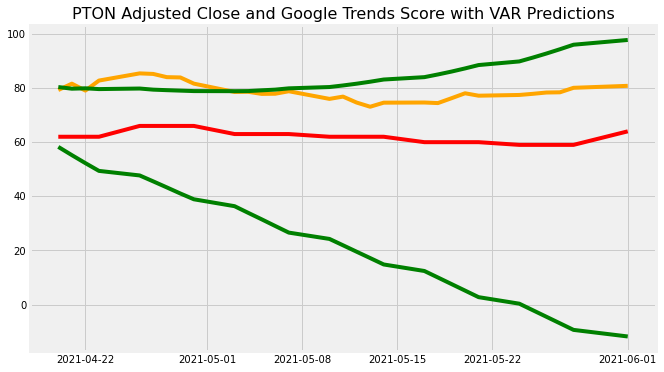

In [232]:
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(close_test.index, pd.DataFrame(close_test)['adjusted_close'], color = 'orange')
plt.plot(close_test.index, pd.DataFrame(close_test)['trend_score'], color = 'red')

# Plot predicted test values.
plt.plot(predicted_adj_close.index, predicted_adj_close, color = 'green')

plt.title(label = 'PTON Adjusted Close and Google Trends Score with VAR Predictions', fontsize=16)
plt.show();